<a href="https://colab.research.google.com/github/SamirGen/ImagesLego/blob/main/CleanTestMaison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 65.4 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Fetched 65.4 kB in 1s (82.4 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 122349

In [2]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

In [3]:
spec = model_spec.get('efficientdet_lite0')

In [20]:
dataloader = object_detector.DataLoader.from_pascal_voc("/images","/annotations", label_map={1: "Maison"})

In [16]:
# split data into training and testing set
import os, random, shutil

os.mkdir('/Maison-detection/train')
os.mkdir('/Maison-detection/test')

image_paths = os.listdir('/images')
annotations_paths = os.listdir('/annotations')
random.shuffle(image_paths)

for i, image_path in enumerate(image_paths):
  if image_path.endswith("checkpoints")==False:
    if i < int(len(image_paths) * 0.8):
      shutil.copy(f'/images/{image_path}', '/Maison-detection/train/')
      shutil.copy(f'/annotations/{image_path.replace("jpg", "xml")}', '/Maison-detection/train/')
    else:
      shutil.copy(f'/images/{image_path}', '/Maison-detection/test/')
      shutil.copy(f'/annotations/{image_path.replace("jpg", "xml")}', '/Maison-detection/test/')

In [22]:
train_data=object_detector.DataLoader.from_pascal_voc("/Maison-detection/train","/Maison-detection/train",label_map={1:"Maison"})
test_datal=object_detector.DataLoader.from_pascal_voc("/Maison-detection/test","/Maison-detection/test",label_map={1:"Maison"})
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=5)

Epoch 1/5
1/1 [==============================] - 45s 45s/step - det_loss: 1.7509 - cls_loss: 1.1298 - box_loss: 0.0124 - reg_l2_loss: 0.0630 - loss: 1.8140 - learning_rate: 0.0080 - gradient_norm: 2.6139
Epoch 2/5
1/1 [==============================] - 1s 1s/step - det_loss: 1.8830 - cls_loss: 1.1488 - box_loss: 0.0147 - reg_l2_loss: 0.0630 - loss: 1.9461 - learning_rate: 0.0043 - gradient_norm: 2.7337
Epoch 3/5
1/1 [==============================] - 2s 2s/step - det_loss: 1.7519 - cls_loss: 1.1510 - box_loss: 0.0120 - reg_l2_loss: 0.0630 - loss: 1.8150 - learning_rate: 0.0025 - gradient_norm: 2.0643
Epoch 4/5
1/1 [==============================] - 3s 3s/step - det_loss: 1.7472 - cls_loss: 1.1473 - box_loss: 0.0120 - reg_l2_loss: 0.0630 - loss: 1.8103 - learning_rate: 7.3223e-04 - gradient_norm: 2.4392
Epoch 5/5
1/1 [==============================] - 2s 2s/step - det_loss: 1.7453 - cls_loss: 1.1478 - box_loss: 0.0119 - reg_l2_loss: 0.0630 - loss: 1.8083 - learning_rate: 0.0000e+00 - gr

In [25]:
model.evaluate(test_datal)

1/1 [==============================] - 4s 4s/step



{'AP': 0.0,
 'AP50': 0.0,
 'AP75': 0.0,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.0,
 'ARmax1': 0.0,
 'ARmax10': 0.0,
 'ARmax100': 0.0,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.0,
 'AP_/Maison': 0.0}

In [26]:
model.export(export_dir='.')

In [27]:
import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

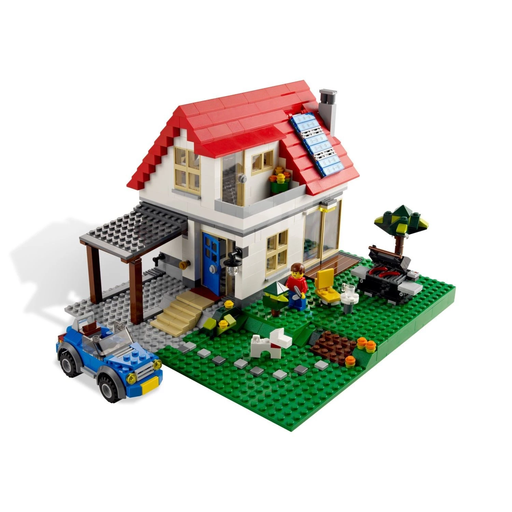

In [31]:
INPUT_IMAGE_URL = "https://cdn.compabrick.fr/resized/products/5771/5771-1500x1500.webp?1620213721"
DETECTION_THRESHOLD = 0.8

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)